In [1]:
%pylab
%matplotlib inline
from importlib import reload
import particleFilter
import pickle
import seaborn as sns
reload(particleFilter)
from particleFilter import forwardSim, MyParticle, ParticlePopulation, multivariate_uniform, plot_posterior_rates
import pandas as pd

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


# creat some toydata

In [2]:
def createData(rates,dt,initial):
    traj =[]
    traj.append(initial)

    # build some observed trajectory
    for i in range(70):
        s, _,_ = forwardSim(iniT=i*dt, iniS=traj[-1], maxTime=i*dt+dt, rates=rates)
        traj.append(s)
    return traj

In [3]:
dt = 600
rates = [0.005, 0.0005, 0.05, 0.0005]
initial = np.array([10,100])

traj = createData(rates,dt,initial)
traj2 = createData(rates,dt,initial)

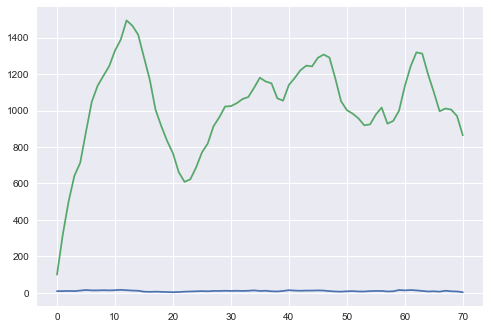

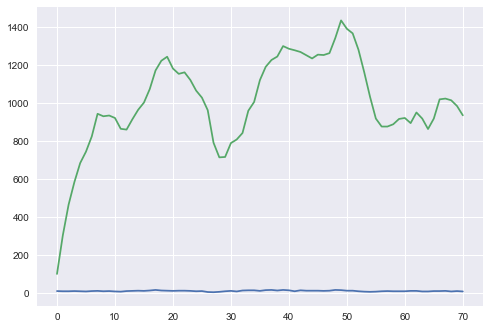

In [4]:
figure()
plot(traj)

figure()
plot(traj2)

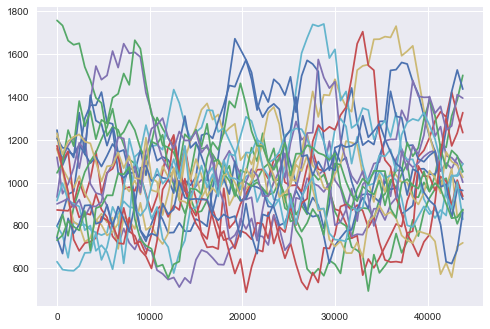

In [5]:
# read from the CSV
df=pd.read_csv('TopicsInCB_data/scenario1.csv', sep=',')
plot(df.values[:,0], df.values[:,1:]);

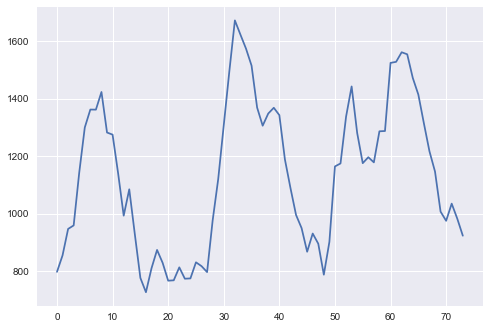

In [6]:
dt = df.values[1,0] - df.values[0,0]
traj_np = df.values[:,1]
plot(traj_np)

traj = []
# put it into this shape i assumed before
for i in range(len(traj_np)):
    traj.append(np.array([-1, traj_np[i]]))

initial = np.array([10,1000])

# using the gamma prior/posterior of rates

In [7]:
from particleFilter import MyGammaParticle
#import progressbar
import multiprocessing as mp
def GammaParticleFilter(nParticles, observedTrajectory, VERBOSE=False, nCores=2):
    
    #create the prior
    prior = ParticlePopulation()
    for i in range(nParticles):
        #p = MyGammaParticle(alpha=np.array([1,1,1,1]),beta=np.array([1,1,1,1]), state=initial)
        p = MyGammaParticle(alpha=np.array([0.5,0.05,5,0.5]),beta=np.array([10,10,10,10]), state=np.array(initial))
        #p = MyGammaParticle(alpha=np.array([0.05,0.005,0.5,0.05]),beta=np.array([100,100,100,100]), state=np.array(initial))
        prior.addParticle(p, 1)
    
    # iteratove posteriors for the next TPs
    populations = [prior]
    
    #bar = progressbar.ProgressBar()
    nTimepoints = len(observedTrajectory)
    for i in range(1,nTimepoints): # for one time step: oen pop
        if VERBOSE:
            print('Population ', i)
            
        lastPop = populations[-1]
#        newPopulation = update_particle_population(lastPop, dt, datapoint=np.array(traj[i][1]))
        #alternative: parallel processing
        print('going paralell')
        newPopulation = update_particle_population_parallel(lastPop, dt, datapoint=np.array(traj[i][1]), nCores=nCores)
        
        assert newPopulation.get_number_of_particles() == nParticles
        populations.append(newPopulation)
        
        # to get a handle on the degeneracy, sample and see how many unique particles we get
        print('unique particles:', 1.0*sum(newPopulation.sample_from_population_ix(nParticles)>0)/nParticles)
        
    
    return populations


def update_particle_population(currentPopulation, dt, datapoint):
    nParticles = currentPopulation.get_number_of_particles()
    newPopulation = ParticlePopulation()
    #sampel a particle from the previous population and calc the weights/udpates
    for newPart in currentPopulation.sample_from_population_generator(nParticles):     
        pa, weight = update_single_particle(newPart, dt, datapoint)
        newPopulation.addParticle(pa, weight)
    return newPopulation

def update_particle_population_parallel(currentPopulation, dt, datapoint, nCores=2):
    """update the population's particles in parallel"""

    assert isinstance(datapoint, np.ndarray), "datapoint should be numpy.array, but is %s" % datapoint.type
    
    nParticles = currentPopulation.get_number_of_particles()
    sample_generator = currentPopulation.sample_from_population_generator(nParticles)
    
    with mp.Pool(processes=nCores) as pool:
        results = [pool.apply_async(update_single_particle, args=(newPart, dt, datapoint)) for newPart in sample_generator]
        # the async call doesnt yield the returns of the function immediatly
        output = [p.get() for p in results]
        
    #aggregate the results into the new population
    newPopulation = ParticlePopulation()
    for pa, weight in output:
        newPopulation.addParticle(pa, weight)
        
    return newPopulation


def update_single_particle(particle, dt, datapoint):
    """
    update a single particle if we see the single datapoint
    also calculate its weight
    """
    weight,state,counter,G = particle.get_weight_single_particle(tau=dt, datapoint=datapoint )

    #update the particle (ie updating the gamma-parameters and the state)
    newAlpha = particle.alpha + counter 
    newBeta = particle.beta + G
    pa = MyGammaParticle(alpha=newAlpha, beta=newBeta, state=state)
    return pa, weight

In [8]:
nParticles = 1000
populationsA = GammaParticleFilter(nParticles,observedTrajectory=traj, VERBOSE=True,nCores=2)
#populationsB = GammaParticleFilter(nParticles,observedTrajectory=traj2, VERBOSE=True)
import pickle
pickle.dump((populationsA, traj), open('/home/icb/michael.strasser/particleFiltering.pkl','wb'))

Population  1
going paralell
unique particles: 0.049
Population  2
going paralell
unique particles: 0.197
Population  3
going paralell
unique particles: 0.307
Population  4
going paralell
unique particles: 0.343
Population  5
going paralell


Process ForkPoolWorker-10:
Traceback (most recent call last):


KeyboardInterrupt: 

In [9]:
populationsA, traj = pickle.load(open('particleFiltering.pkl','rb'))

## Eval

/home/michi/pythonProjects/particleFilter/particleFilter.py:62: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  pd.scatter_matrix(df,figsize=[20,20],marker='x') # c=df.Survived.apply(lambda x:colors[x])


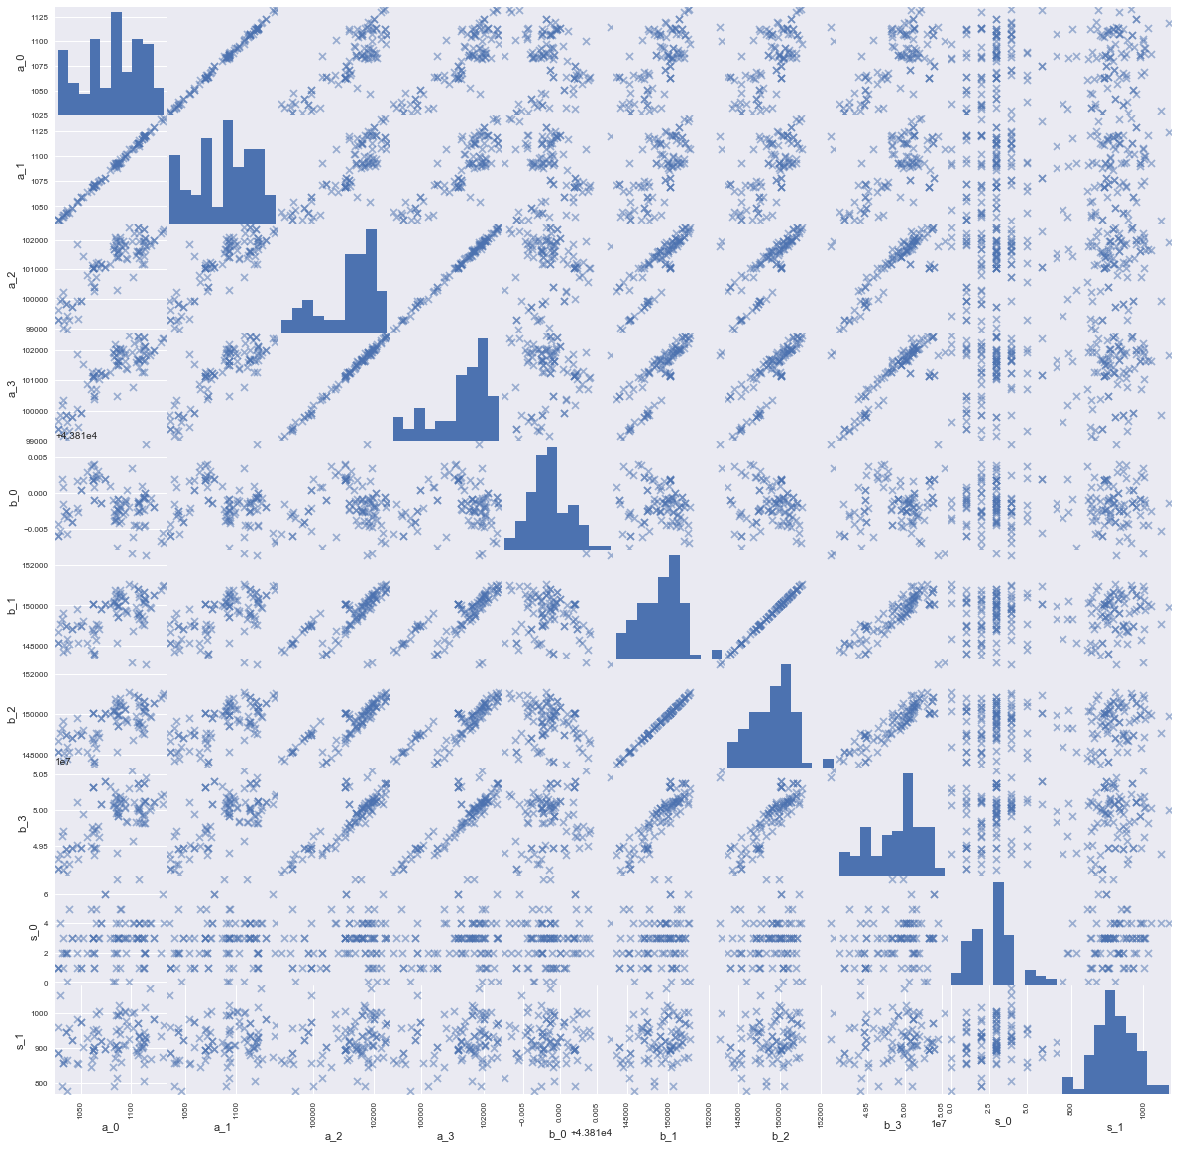

In [10]:
populationsA[-1].plot_population_sample(100)
#populationsB[-1].plot_population_sample(100)

In [11]:
populations = populationsA

In [12]:
def plot_posterior_rates(population, nParticles):
    """a particle encodes a whole distrinbution over rates
    hence sample from this distribution to get the posterior over the rates"""

    samples_per_particle = 100
    ratesSamples = []
    colors = []
    for i, particle in enumerate(population.sample_from_population_generator(nParticles)):
        #sample the rates n tims from this distribution the particle encodes
        q = [particle.sampleRates(1) for i in range(samples_per_particle)]
        w = [i for j in range(samples_per_particle)]
        ratesSamples.append(q)
        colors.append(w)
    ratesSamples = np.vstack(ratesSamples)
    colors = np.vstack(colors)

    df = pd.DataFrame(ratesSamples)
    pd.scatter_matrix(df,figsize=[20,20],marker='x',c=colors, cmap = cm.jet)

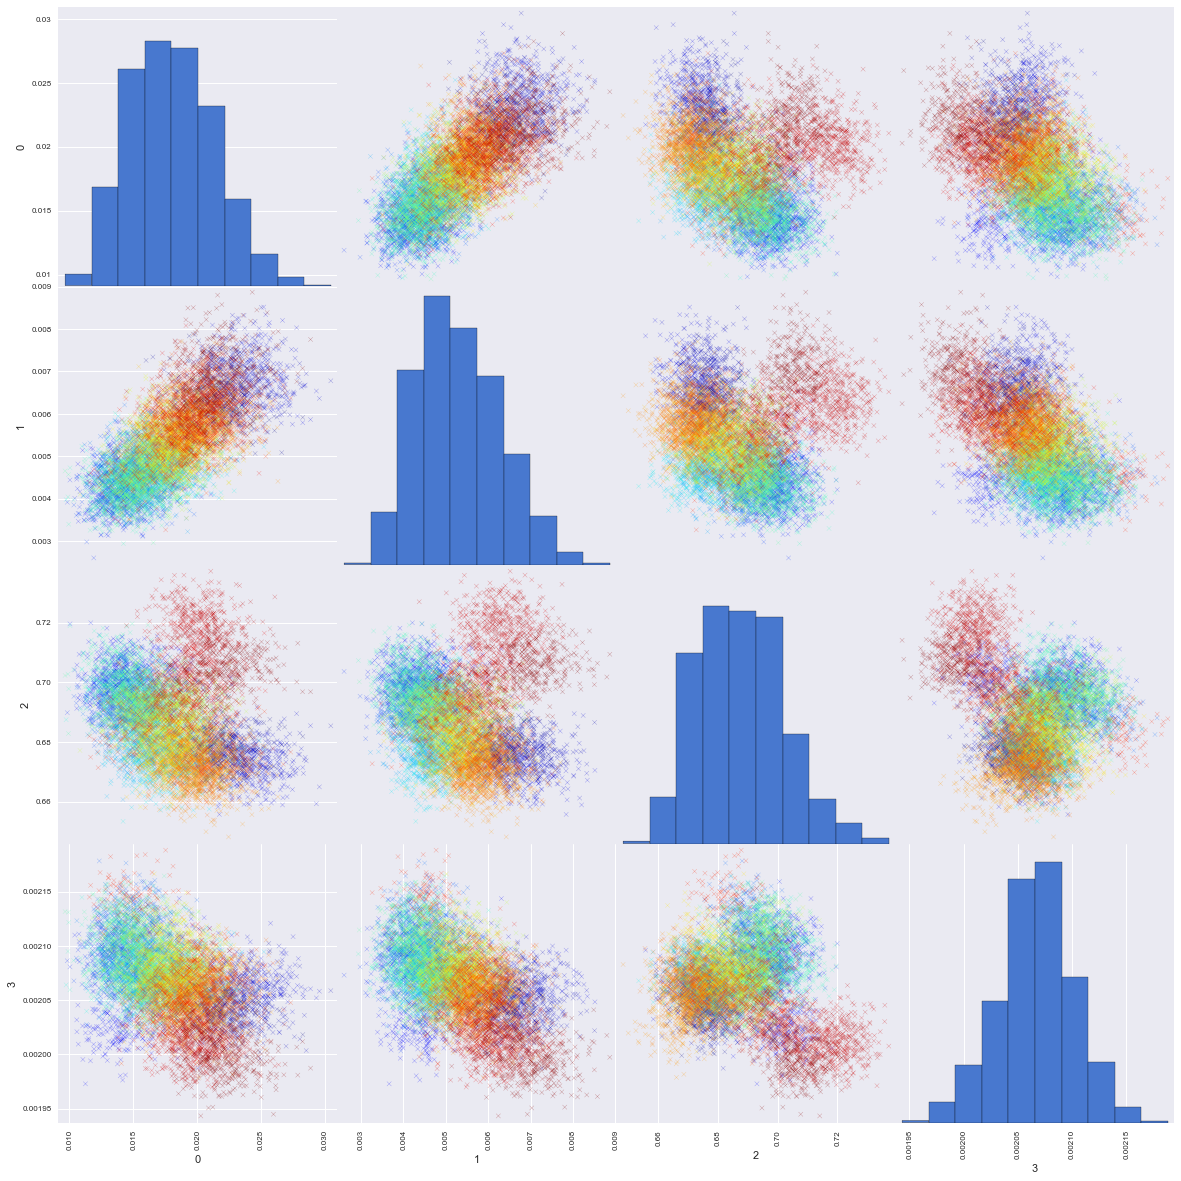

In [54]:
plot_posterior_rates(populations[10], 100)

In [ ]:
for i, pop in enumerate(populations):
    m = pop.sample_from_population_matrix(nSamples)

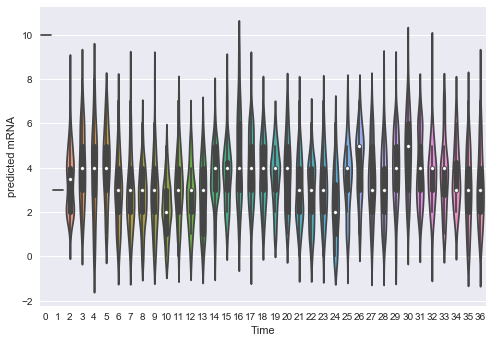

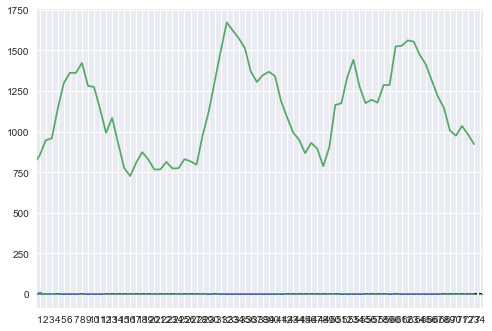

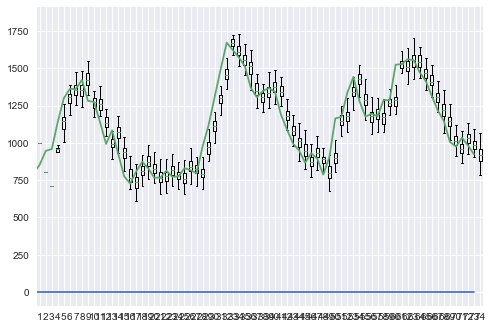

In [14]:
# plot the hidden state trajectory
nSamples = 100
RNA_over_time = zeros((nSamples, len(traj)))
protein_over_time = zeros((nSamples, len(traj)))
for i, pop in enumerate(populations):
    m = pop.sample_from_population_matrix(nSamples)
    RNA_over_time[:,i] = m[:,8]
    protein_over_time[:,i] = m[:,9]
import seaborn as sns
figure()
sns.violinplot(data=RNA_over_time[:,::2])
xlabel('Time')
ylabel('predicted mRNA')

figure()
boxplot(RNA_over_time);
plot(traj) ;

figure()
boxplot(protein_over_time);
plot(traj) ;

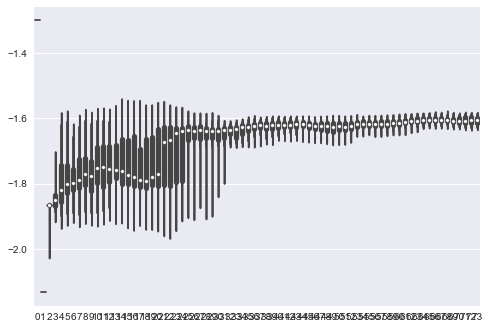

In [15]:
# plot the parameters trajectory
nSamples = 500
theta_over_time = zeros((nSamples, len(traj)))

for i, pop in enumerate(populations):
    m = pop.sample_from_population_matrix(nSamples)
    theta_over_time[:,i] = m[:,0]/m[:,4]
import seaborn as sns
figure();
sns.violinplot(data=log10(theta_over_time))

/home/michi/anaconda3/envs/py36_keras/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  """


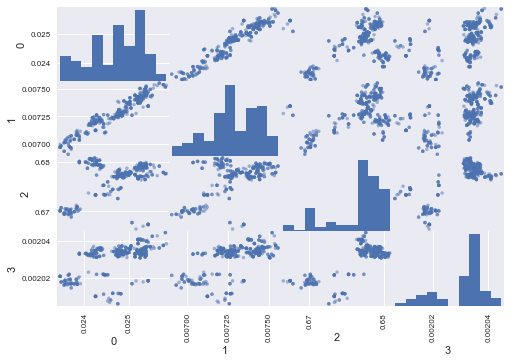

In [16]:
lastPop = populations[-1]
m = lastPop.sample_from_population_matrix(nSamples)

meanRates = np.array([m[:,0]/m[:,4], m[:,1]/m[:,5], m[:,2]/m[:,6], m[:,3]/m[:,7] ]).T
pd.scatter_matrix(pd.DataFrame(meanRates));

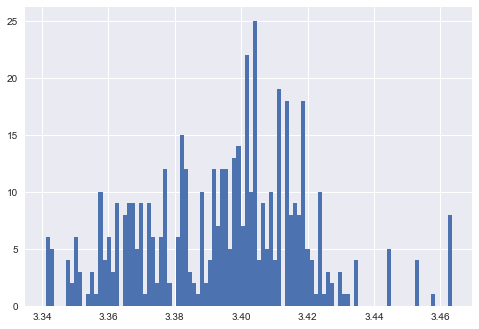

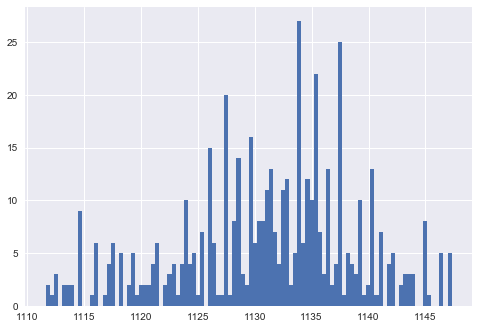

In [17]:
rnaSTST = meanRates[:,0]/meanRates[:,1]
proteinSTST = rnaSTST * meanRates[:,2]/meanRates[:,3]
figure();
hist(rnaSTST,100);
#*meanRates[:,2]/(*meanRates[:3])

figure();
hist(proteinSTST,100);

# siome cython testing

In [46]:
import pyximport; pyximport.install()
from SSA import forwardSim, forwardSim_cython

In [41]:
%timeit forwardSim(0, [0,0], 10000, rates)

1 loops, best of 3: 2.29 s per loop


In [42]:
%timeit forwardSim_cython(0, np.array([0,0]), 10000, np.array(rates))

1 loops, best of 3: 1.51 s per loop


In [47]:
import pstats, cProfile
cProfile.runctx("forwardSim_cython(0, np.array([0,0]), 10000, np.array(rates))", globals(), locals(), "Profile.prof")
cProfile.runctx("forwardSim(0, np.array([0,0]), 10000, np.array(rates))", globals(), locals(), "Profile_slow.prof")

In [44]:
s = pstats.Stats("Profile_slow.prof")
s.strip_dirs().sort_stats("time").print_stats()

Fri Dec 18 16:01:12 2015    Profile_slow.prof

         193034 function calls in 1.833 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    1.606    1.606    1.832    1.832 {SSA.forwardSim}
    96514    0.177    0.000    0.177    0.000 {method 'cumsum' of 'numpy.ndarray' objects}
    96514    0.050    0.000    0.227    0.000 fromnumeric.py:2038(cumsum)
        1    0.000    0.000    1.833    1.833 {built-in method builtins.exec}
        2    0.000    0.000    0.000    0.000 {built-in method numpy.core.multiarray.array}
        1    0.000    0.000    1.833    1.833 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [45]:
s = pstats.Stats("Profile.prof")
s.strip_dirs().sort_stats("time").print_stats()

Fri Dec 18 16:01:10 2015    Profile.prof

         219714 function calls in 2.066 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    1.800    1.800    2.066    2.066 {SSA.forwardSim_cython}
   109854    0.203    0.000    0.203    0.000 {method 'cumsum' of 'numpy.ndarray' objects}
   109854    0.063    0.000    0.266    0.000 fromnumeric.py:2038(cumsum)
        1    0.000    0.000    2.066    2.066 {built-in method builtins.exec}
        2    0.000    0.000    0.000    0.000 {built-in method numpy.core.multiarray.array}
        1    0.000    0.000    2.066    2.066 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [48]:
s = pstats.Stats("Profile.prof")
s.strip_dirs().sort_stats("time").print_stats()

Fri Dec 18 16:01:59 2015    Profile.prof

         199484 function calls in 2.305 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    2.005    2.005    2.305    2.305 {SSA.forwardSim_cython}
    99739    0.229    0.000    0.229    0.000 {method 'cumsum' of 'numpy.ndarray' objects}
    99739    0.071    0.000    0.300    0.000 fromnumeric.py:2038(cumsum)
        1    0.000    0.000    2.305    2.305 {built-in method builtins.exec}
        2    0.000    0.000    0.000    0.000 {built-in method numpy.core.multiarray.array}
        1    0.000    0.000    2.305    2.305 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}


